In [1]:
# use widgets as matplotlib backend
%matplotlib widget

# imports
from matplotlib import pyplot as plt
import os
import numpy
import os, sys
from time import time
from tqdm.auto import tqdm
from collections import defaultdict
import numpy as np
import matplotlib as mpl

# import the file object for opening kongsberg files
# Note: function and library naming to be discussed
from themachinethatgoesping.echosounders import kongsbergall
from themachinethatgoesping.echosounders import index_functions
from themachinethatgoesping.pingprocessing import filter_pings

#simplify creating figures
mpl.rcParams['figure.dpi'] = 100
close_plots = True

def create_figure(name, return_ax=True):
    if close_plots: plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

In [2]:
# list of folders with kongsberg .all or .wcd files (subfolders will be scanned as well)

folder = "../../unittest_data/"

# list raw data files
files = index_functions.find_files(folder, [".all","wcd"])
cacheFilePaths = index_functions.get_index_paths(file_paths=files)
files.sort()
            
files.sort()
file_name = files[0]
print("files:      ", len(files))

Found 18 files
files:       18


## Open all files
The function 
Notes: 
1. KongsbergAllFileHandler(files) scanns and indexes all files and provides access to all files like a combined file stream
2. If a .all and a .wcd files with the same name (one .all and one .wcd) are added, they will be matched to a single file
3. It is not possible to add two .all or two .wcd with the same name, even if they are within different folders
4. Note: if the files are not sorted in time, the datagram packages will not be sorted by time either, however it isi simple to sort the pings at a later stage

In [3]:
# Index all files and initialize the file interfaces
# fm will be the accessor
fm = kongsbergall.KongsbergAllFileHandler(files)

#print some information about the files that where indexed
print(fm)

indexing files ⠐ 100% :00s<00m:00s] [..0871266855321420.all (1/18)]                               
indexing files ⠠ 100% :00s<00m:00s] [..3008643552583898.wcd (18/18)]                                
indexing files ⢀ 100% :00s<00m:00s] [Found: 729 datagrams in 18 files (10MB)]                                         
Initializing ping interface ⢀ 90% :00s<00m:00s] [Done]                                              
KongsbergAllFileHandler
#######################
-
File infos 
-------------               
- Number of loaded .all files: : 10       
- Number of loaded .wcd files: : 8        
- Total file size: :             10.71 MB 

 Detected datagrams 
^^^^^^^^^^^^^^^^^^^^ 
- timestamp_first:  21/08/2012 17:09:42.36 
- timestamp_last:   26/07/2024 15:02:51.40 
- Total:            729                    
- Datagrams [0x30]: 3                      [PUIDOutput]
- Datagrams [0x31]: 9                      [PUStatusOutput]
- Datagrams [0x33]: 3                      [ExtraParameters]
- Datag

## Advanced access to ping data
1. Ping file objects typically combine many files
2. The interface to access the pings of these files imitates a container that can e.g. be sliced to extract a subset of pings
3. Additionally, some convinient functions are supplied that make working with the data easier
4. Note: The interface is not yet ready. Because of this we have to use a number of raw datagram access to achive the plotting.
5. Naturally this interface will be greatly simplified in the comming months

In [4]:
# Create a ping container that is sorted in time. Because of the sorting you do not need to 
# worry about supplying the input files in correct file order

pings_sorted = fm.get_pings()

# Now we split the dataset into stations. We here assume that recording data was turned of between stations.
# split_by_time_diff will split the data if the timedifference between two subsequent pings is larger than arg
# Note: for this function to make sense the pings should be sorted_in_time
# Here we split the data if the time difference was larger than half an hour
ping_containers = pings_sorted.split_by_time_diff(1800)


for i,c in enumerate(ping_containers):
    print(i, len(c))

0 6
1 35
2 6
3 9
4 7
5 8
6 8
7 6


## Extract and plot navigation data
1. The navigation interface is not yet ready, but we can already get the navigation of each transducer and put it into a list

In [5]:
lat = []
lon = []
time = []
nav_locations = defaultdict(list)
for i, pings in enumerate(ping_containers):
    for p in tqdm(pings):
        try:
            # we just use the location of the first transduce rhere
            g = p.get_geolocation()
            lat.append(g.latitude)
            lon.append(g.longitude)
            time.append(p.get_timestamp())
            nav_locations[i].append([g.latitude,g.longitude])
        except:
            pass


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
# This code uses ipyleaflet for plotting the navigaiton data on background map (needs internet)
# the code is thus unreleated to ping

from ipyleaflet import Map, basemaps, basemap_to_tiles, AntPath, projections, Marker, AwesomeIcon
from ipywidgets import Layout, HTML
from matplotlib import colormaps,colors

cmap = colormaps.get_cmap("Set1")

m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.NatGeoWorldMap),
    center=(np.nanmedian(lat), np.nanmedian(lon)),
    layout=Layout(width='80%', height='600px'),
    zoom=9,
    crs=projections.EPSG3857
)

for k,n in nav_locations.items():
    ant_path = AntPath(
        locations=n,
        # dash_array=[1, 10],
        # delay=1000,
        color=colors.to_hex(cmap(k))
        # pulse_color='#3f6fba'
    )

    m.add(ant_path)

    icon = AwesomeIcon(
        name='ship',
        marker_color="white",
        icon_color=colors.to_hex(cmap(k)),
        #spin=True
        )
    marker = Marker(
        location = n[0],
        icon=icon,
        title=str(k)
    )
    message = HTML()
    message.value = str(k)
    marker.popup = message

    m.add(marker)


# marker = Marker(location = nav_locations[2][16764])
# m.add(marker)
# marker = Marker(location = nav_locations[2][17422])
# m.add(marker)
# marker = Marker(location = nav_locations[2][17730])
# m.add(marker)

m


Map(center=[np.float64(51.492035354362585), np.float64(26.794886268723854)], controls=(ZoomControl(options=['p…

In [7]:
# Note if you click on a marker above, it will tell you the station number (in the ping_containers array)

# Select a station for plotting (here 0)

In [8]:
#pings = ping_containers[0]
pings = fm.get_pings()

#filter pings to include water column informatiopen
pings = filter_pings.by_features(pings, ["watercolumn"])

print(len(pings))
# uncommenting this code will downsample the data to only plot every 5th ping
scalor = 5
#pings = pings[::scalor]
print(scalor)
print(len(pings))

74
5
74


  0%|          | 0/74 [00:00<?, ?it/s]

error: 60 min() iterable argument is empty | <class 'ValueError'>
error: 62 min() iterable argument is empty | <class 'ValueError'>
error: 64 min() iterable argument is empty | <class 'ValueError'>
error: 66 min() iterable argument is empty | <class 'ValueError'>


  0%|          | 0/74 [00:00<?, ?it/s]

error: 70 list index out of range | <class 'IndexError'>
error: 71 list index out of range | <class 'IndexError'>
error: 72 list index out of range | <class 'IndexError'>
error: 73 list index out of range | <class 'IndexError'>


/tmp/ipykernel_50101/2636436475.py:49: RuntimeWarning: Mean of empty slice
  a[:m] = np.nanmean(samples,axis=0)[:m]
/tmp/ipykernel_50101/2636436475.py:52: RuntimeWarning: Mean of empty slice
  data[i][:] = np.nanmean(A,axis=0)


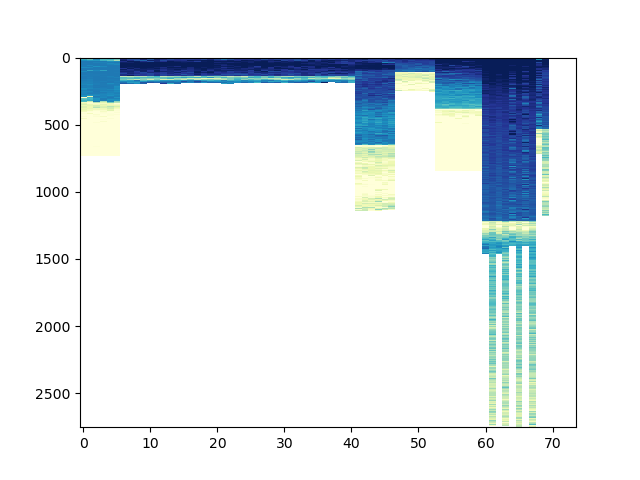

In [9]:
#set the beam angle range in degrees
beam_angle_min = 30
beam_angle_max = 60


#first loop, get statistics
max_s = 0
beams = []
max_transducer_ids = 0
for i,p in enumerate(tqdm(pings)):
    try:        
        w = p.file_data.read_merged_watercolumndatagram(skip_data=True)
        
        tmp_beams = []
        tmp_max_samples = [max_s]
        
        for ib,b in enumerate(w.beams()):
            if b.get_beam_crosstrack_angle_in_degrees() < beam_angle_min:
                continue
            if b.get_beam_crosstrack_angle_in_degrees() > beam_angle_max:
                continue
            tmp_beams.append(ib)
            tmp_max_samples.append(b.get_number_of_samples())

        max_s = np.nanmax(tmp_max_samples)
        beams.append((min(tmp_beams),max(tmp_beams)))
    except IndexError as e:
        print("error:",i,e,"|",type(e))
    except ValueError as e:
        print("error:",i,e,"|",type(e))
    except RuntimeError as e:
        print("error:",i,e,"|",type(e))



data = np.empty((len(pings),max_s))
data.fill(np.nan)
index = 0

for i,p in enumerate(tqdm(pings)):
    try:
        A = []
        w = p.file_data.read_merged_watercolumndatagram()
        samples = w.get_samples()[beams[index][0]:beams[index][1]]
        index += 1

        m = min(samples.shape[1], max_s)
        a = data[i].copy()
        a[:m] = np.nanmean(samples,axis=0)[:m]
        A.append(a)

        data[i][:] = np.nanmean(A,axis=0)

    except IndexError as e:
        print("error:",i,e,"|",type(e))
    except ValueError as e:
        print("error:",i,e,"|",type(e))
    except RuntimeError as e:
        print("error:",i,e,"|",type(e))

fig,ax = create_figure("test")

ax.imshow(data.transpose(),aspect='auto',cmap='YlGnBu_r',vmin=-80, vmax = -30, interpolation='nearest')

interactive(children=(FloatSlider(value=-100.0, description='cmin', max=-50.0, min=-150.0, step=0.5), IntSlide…

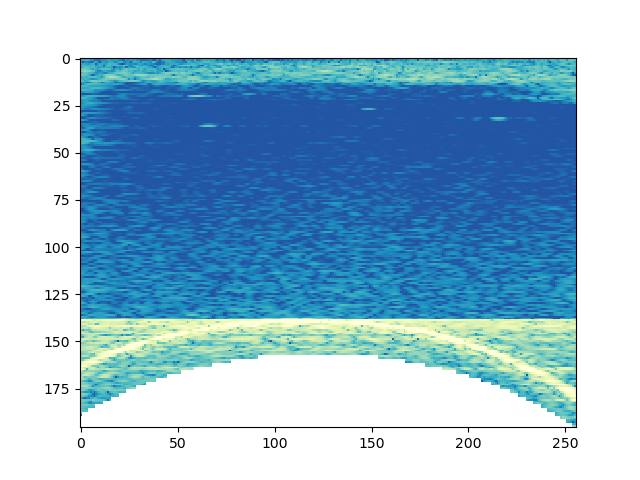

In [10]:

from ipywidgets import *
fig_slices = create_figure('wci',False)
ax = fig_slices.subplots()

def update(cmin = (-150,
                  -50,
                  0.5),
           wci_index=(0,len(pings)-1,1)):
    global fig_slices, local_image, cb
    
    try:
        ax.clear()
            
        p = pings[wci_index]
        
        w = p.file_data.read_merged_watercolumndatagram().get_samples()

        mapable = ax.imshow(w.transpose(),aspect='auto',cmap='YlGnBu_r',vmin=cmin, vmax = -30, interpolation='nearest')
        
        
    except Exception as e:
        print(e)
        #pass
        raise (e)
           
    

interact(update);